---
# Loading all configs
---

In [1]:
import yaml
import pandas as pd
from pathlib import Path

_dict = {'line_ID':[],'config':[],'Energy':[],'I_bbcw':350,'I_oct':[],'Nb':[],'emitt_strong':[],'emitt_weak':[],'xing': []}
for ff in sorted(list(Path('Tracking/').glob(f'coordinates_*.pkl'))):
    line_ID = ff.stem.split('coordinates_')[1]
    if 'emitt' in line_ID:
        continue

    
    _dict['line_ID'].append(line_ID)


    if 'xing' in line_ID:
        with open(f'Configs/config_{line_ID}.yaml') as fid:
            configuration = yaml.safe_load(fid)
        _dict['config'].append(f'Configs/config_{line_ID}.yaml')
        
        _dict['Energy'].append(configuration['beam_energy_tot'])
        _dict['Nb'].append(configuration['beam_npart'])
        _dict['I_oct'].append(configuration['oct_current'])
        
        assert float(configuration['beam_norm_emit_x'])== float(configuration['beam_norm_emit_y'])
        _dict['emitt_strong'].append(configuration['beam_norm_emit_x'])
        _dict['emitt_weak'].append(configuration['beam_norm_emit_x'])
        
        _dict['xing'].append(configuration['knob_settings']['on_x1'])
        continue
    if 'strong' in line_ID:
        with open(f'Configs/config_{line_ID.split("base_")[1]}.yaml') as fid:
            configuration = yaml.safe_load(fid)
        _dict['config'].append(f'Configs/config_{line_ID.split("base_")[1]}.yaml')
        
        _dict['Energy'].append(configuration['beam_energy_tot'])
        _dict['Nb'].append(configuration['beam_npart'])
        _dict['I_oct'].append(configuration['oct_current'])
        
        assert float(configuration['beam_norm_emit_x'])== float(configuration['beam_norm_emit_y'])
        _dict['emitt_strong'].append(configuration['beam_norm_emit_x'])
        _dict['emitt_weak'].append(2.3)
        
        _dict['xing'].append(configuration['knob_settings']['on_x1'])
        continue

    if ('base' in line_ID)&('strong' not in line_ID):
        with open(f'Configs/config_base.yaml') as fid:
            configuration = yaml.safe_load(fid)
        _dict['config'].append(f'Configs/config_base.yaml')
        
        _dict['Energy'].append(configuration['beam_energy_tot'])
        _dict['Nb'].append(configuration['beam_npart'])
        _dict['I_oct'].append(configuration['oct_current'])
        
        assert float(configuration['beam_norm_emit_x'])== float(configuration['beam_norm_emit_y'])
        _dict['emitt_strong'].append(configuration['beam_norm_emit_x'])
        
        if 'weak' in line_ID:
            emitt_ID = line_ID.split('base_weak_')[1]
            _dict['emitt_weak'].append({'01':1.9,'02':2.1,'03':2.3,'04':2.5}[emitt_ID])
        else:
            _dict['emitt_weak'].append(configuration['beam_norm_emit_x'])
        
        _dict['xing'].append(configuration['knob_settings']['on_x1'])

Allconfigs = pd.DataFrame(_dict).set_index('line_ID')
display(Allconfigs)


,config,Energy,I_bbcw,I_oct,Nb,emitt_strong,emitt_weak,xing
line_ID,,,,,,,,
base,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.3,160
base_strong_01,Configs/config_strong_01.yaml,6800,350,430,1.4e11,1.9,2.3,160
base_strong_02,Configs/config_strong_02.yaml,6800,350,430,1.4e11,2.1,2.3,160
base_strong_03,Configs/config_strong_03.yaml,6800,350,430,1.4e11,2.3,2.3,160
base_strong_04,Configs/config_strong_04.yaml,6800,350,430,1.4e11,2.5,2.3,160
base_weak_01,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,1.9,160
base_weak_02,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.1,160
base_weak_03,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.3,160
base_weak_04,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.5,160


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sciStat
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os


# os.chdir('/eos/user/p/phbelang/Programming/Octupoles_Guido/')

# source /home/phbelang/abp/BBStudies/Executables/py_BB/bin/activate
# if 'BBStudies/Executables/py_BB/bin' not in os.environ.get('PATH').split(':')[0]:
#     raise Exception('Wrong Python Distribution, use BBStudies/Executables/py_BB')



import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf

sys.path.append('/home/phbelang/abp/BBStudies/')
# Linux local
sys.path.append('/home/pbelanger/ABPlocal/BBStudies')
# Mac local
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies/')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst



def load_tracked(line_ID,sf=10):
    tracked = {}
    for label in ['ref','HO','LR','OCTU','BBCW']:
        tracked[label] = pd.read_pickle(f'Tracking/tracked_{label}_sf{sf}_{line_ID}.pkl')
    tracked['coord'] = pd.read_pickle(f'Tracking/coordinates_{line_ID}.pkl')
    tracked['sf'] = sf
    _coord = tracked['coord']
    ctour_idx  = list(_coord[_coord['theta_sig'] == np.min(_coord['theta_sig'])].index)
    ctour_idx += list(_coord[_coord['r_sig'] == np.max(_coord['r_sig'])].index)[1:-1]
    ctour_idx += list(_coord[_coord['theta_sig'] == np.max(_coord['theta_sig'])].index)[::-1]
    ctour_idx += list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)[1:-1][::-1]
    tracked['ctour_idx'] = ctour_idx

    tracked['co'] = list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)
    tracked['not_co'] = list(_coord[_coord['r_sig'] != np.min(_coord['r_sig'])].index)

    tracked['safe_theta'] = list(_coord[(_coord['theta_sig']>0.05*np.pi/2)&(_coord['theta_sig']<0.95*np.pi/2)].index)
    return tracked



def sum_footprints(_tracked,components,l_ID = 'base',contour = False,at_intensity = None,at_current = None,at_mo_current = None):
    dQx,dQy = np.zeros(len(_tracked['coord'])),np.zeros(len(_tracked['coord']))

    rescale = {'HO':1,'LR':1,'BBCW':1,'OCTU':1}
    if at_intensity is not None:
        rescale['HO'] = at_intensity/float(Allconfigs.loc[l_ID,'Nb'])
        rescale['LR'] = at_intensity/float(Allconfigs.loc[l_ID,'Nb'])
    if at_current is not None:
        rescale['BBCW'] = at_current/float(Allconfigs.loc[l_ID,'I_bbcw'])
    if at_mo_current is not None:
        rescale['OCTU'] = at_mo_current/float(Allconfigs.loc[l_ID,'I_oct'])

    for i in components:
    #---------------
        _dQx = _tracked[i].tunes_n['Qx'] - _tracked['ref'].tunes_n['Qx']
        _dQy = _tracked[i].tunes_n['Qy'] - _tracked['ref'].tunes_n['Qy']

        # Scale for scale_strength factor
        dQx += _dQx*_tracked['sf']*rescale[i]
        dQy += _dQy*_tracked['sf']*rescale[i]
    #---------------


    if contour:

        dQx,dQy = dQx.loc[_tracked['ctour_idx']],dQy.loc[_tracked['ctour_idx']]
    
    return dQx,dQy


def octupole_footprint(_tracked,_mo_df,gamma0,l_ID = 'base',contour=False):

    emitt = float(Allconfigs.loc[l_ID,'emitt_weak'])
    dQx,dQy = np.zeros(len(_tracked['coord'])),np.zeros(len(_tracked['coord']))

    for idx,mo in _mo_df.iterrows():
        #---------------
        _dQx,_dQy = dtune.DQx_DQy_octupole( _tracked['coord']['x_sig'],
                                            _tracked['coord']['y_sig'],
                                            betxy   = mo[['betx','bety']],
                                            emittxy = np.array([emitt*1e-6,emitt*1e-6])/gamma0,
                                            k1l     = 0,
                                            k3l     = mo['k3l'])


        dQx += _dQx
        dQy += _dQy
        #---------------

    if contour:
        dQx,dQy = dQx.loc[_tracked['ctour_idx']],dQy.loc[_tracked['ctour_idx']]
    
    return dQx,dQy


LINEFOLDER = './Lines/'
def import_from_lines(line_ID,to_track='b4'):
    line   = {}
    twiss  = {}
    survey = {}
    tracker_b1 = None
    tracker_b4 = None
    for seq in ['lhcb4']:
        _beam = seq[-2:]
        # Importing Line
        line[_beam] = xPlus.importLine(LINEFOLDER + f'line_{line_ID}_{seq}.json')
        
        # Importing twiss and tracker
        if _beam == 'b1':
            tracker_b1    = xt.Tracker(line=line[_beam])
            twiss[_beam]  = tracker_b1.twiss().to_pandas(index="name")
            survey[_beam] = tracker_b1.survey().to_pandas(index="name")
        elif _beam == 'b4':
            tracker_b4    = xt.Tracker(line=line[_beam])
            twiss[_beam]   = tracker_b4.twiss().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().to_pandas(index="name")

            _beam = 'b2'
            twiss[_beam]   = tracker_b4.twiss().reverse().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().reverse().to_pandas(index="name")


    if to_track == 'b1':
        tracker = tracker_b1
        del tracker_b4
    else:
        tracker = tracker_b4
        del tracker_b1
    # Clearing xsuite ouput
    clear_output(wait=False)



    allVars = list(tracker.vars._owner.keys())
    allElements = list(tracker.element_refs._owner.keys())


    # Deactivating all wires
    #===================================================
    tracker.vars['enable_qff'] = 0
    for IP in ['ip1','ip5']:
        tracker.vars[f"bbcw_rw_{IP}.{_beam}"] = 1
        tracker.vars[f"bbcw_i_{IP}.{_beam}"]  = 0
    run3_wires = [name for name in allElements if ('bbcw' in name)&('wire' in name)]
    for wire in run3_wires:
        tracker.line.element_dict[wire].post_subtract_px  = 0
        tracker.line.element_dict[wire].post_subtract_py  = 0
        
    # Creating BB knobs
    #===================================================
    
    for _ip in ['ip1','ip5','ip2','ip8']:
        bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}{_beam}' in name)]
        bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}{_beam}' in name)]

        # New knob:
        tracker.vars[f'{_ip}_bblr_ON'] = 1
        tracker.vars[f'{_ip}_bbho_ON'] = 1

        # Linking to new knob 
        for _lr in bb_lr:
            # Infividual knobs
            tracker.vars[f'{_lr}_ON'] = 1
            tracker.element_refs[_lr].scale_strength = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].scale_strength._value

        for _ho in bb_ho:
            tracker.element_refs[_ho].scale_strength = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].scale_strength._value

    for _ip in ['ip1','ip5','ip2','ip8']:
        tracker.vars[f'{_ip}_bblr_ON'] = 0
        tracker.vars[f'{_ip}_bbho_ON'] = 0


    # Creating sext and oct knobs
    #====================================================

    # AS DONE IN THE MASK
    #---------------------
    part = tracker.line.particle_ref
    brho = part.p0c[0]/(part.q0*cst.c)
    tracker.vars['I_oct'] = 0
    for ss in '12 23 34 45 56 67 78 81'.split():
        tracker.vars[f'kof.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
        tracker.vars[f'kod.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
    #---------------------

    
    ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
    ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

    tracker.vars['all_oct_ON']  = 1
    tracker.vars['all_sext_ON'] = 1
    for _ks in ks:
        if tracker.vars[_ks]._expr is None:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
        else:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
    for _ko in ko:
        if tracker.vars[_ko]._expr is None:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
        else:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

    return tracker,line,twiss,survey




---
# Coordinates
---

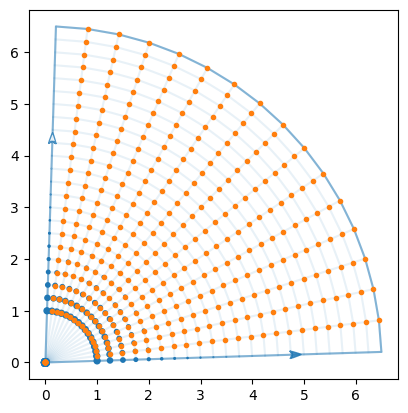

In [4]:
line_ID = 'base'
tracked = load_tracked(line_ID )


plt.figure()
bbplt.polarmesh(tracked['coord']['x_sig'],tracked['coord']['y_sig'],alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color='C0')
plt.scatter(tracked['coord']['x_sig'],tracked['coord']['y_sig'],c='C0',s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0))



# Plotting contour and Jx/J_y
color = 'C0'
dQx,dQy = tracked['coord']['x_sig'],tracked['coord']['y_sig']

dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)

start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+3
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+3
bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
plt.axis('square');

color = 'C1'
dQx,dQy = tracked['coord']['x_sig'],tracked['coord']['y_sig']

#0.05*np.pi/2,0.95*np.pi/2
dQx,dQy = dQx.loc[tracked['safe_theta']],dQy.loc[tracked['safe_theta']]
plt.plot(dQx,dQy,'.',color='C1')



---
# Loading all tracked | base plot
---

In [24]:
AllTracked = {}
for line_ID in Allconfigs.index:
    AllTracked[line_ID] = load_tracked(line_ID)

def template_FP_plot(window = 0.004):

    Qx_0,Qy_0 = 0.31, 0.32
    Qx_lim    = [Qx_0-4*window/6,Qx_0+2*window/6]
    Qy_lim    = [Qy_0-4*window/6,Qy_0+2*window/6]

    plt.figure(figsize=(8,6))
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [-Qx_0,-Qy_0],alpha=0.15,color='grey')
    h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)


    plt.axis('square')
    plt.xlim(np.array(Qx_lim)-Qx_0)
    plt.ylim(np.array(Qy_lim)-Qy_0)


    plt.xlabel(rf'$\Delta Q_x$',fontsize=16)
    plt.ylabel(rf'$\Delta Q_y$',fontsize=16)


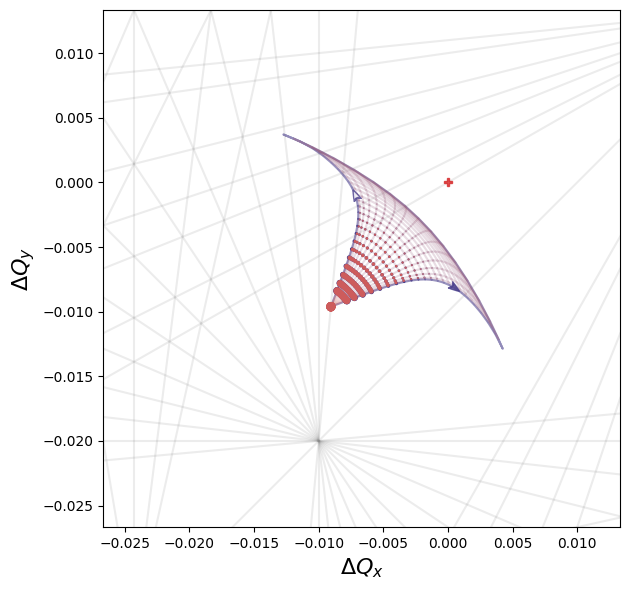

In [30]:


line_ID = 'base'

tracked = AllTracked[line_ID]
template_FP_plot(window = 0.04)

color = 'darkslateblue'

#---------------------------------------------------------
# Computing footprint
dQx,dQy = sum_footprints(tracked,components = ['HO','LR'])
_dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
plt.scatter(_dQx,_dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

# Plotting contour and Jx/J_y
dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
plt.plot(dQx,dQy,'-',alpha=0.5,color=color)

start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+3
bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+3
bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
#---------------------------------------------------------

color = 'indianred'

#---------------------------------------------------------
# Computing footprint
dQx,dQy = sum_footprints(tracked,components = ['HO','LR'])
_dQx,_dQy = dQx.loc[tracked['safe_theta']],dQy.loc[tracked['safe_theta']]
bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
plt.scatter(_dQx,_dQy,c=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

#---------------------------------------------------------


plt.tight_layout()


---
# Comparing xing
---

In [13]:
Allconfigs

,config,Energy,I_bbcw,I_oct,Nb,emitt_strong,emitt_weak,xing
line_ID,,,,,,,,
base,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.3,160
base_strong_01,Configs/config_strong_01.yaml,6800,350,430,1.4e11,1.9,2.3,160
base_strong_02,Configs/config_strong_02.yaml,6800,350,430,1.4e11,2.1,2.3,160
base_strong_03,Configs/config_strong_03.yaml,6800,350,430,1.4e11,2.3,2.3,160
base_strong_04,Configs/config_strong_04.yaml,6800,350,430,1.4e11,2.5,2.3,160
base_weak_01,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,1.9,160
base_weak_02,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.1,160
base_weak_03,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.3,160
base_weak_04,Configs/config_base.yaml,6800,350,430,1.4e11,2.3,2.5,160


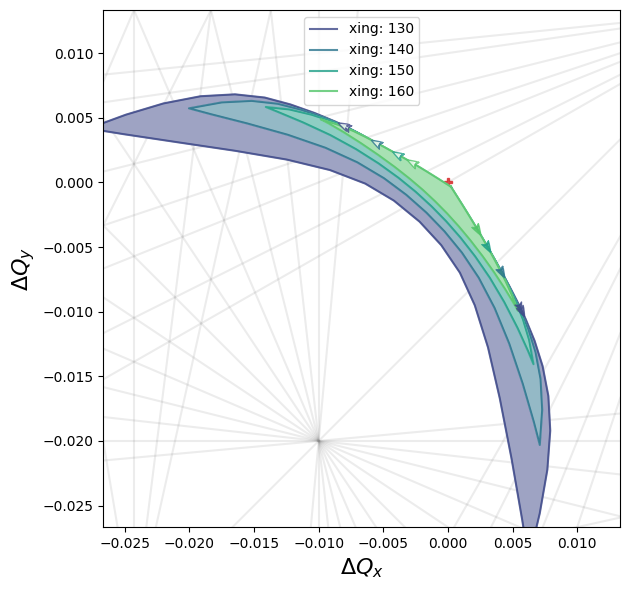

In [60]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*130,vmax=1.1*160,cmap='viridis')

for line_ID in Allconfigs.index[::-1]:
    if 'xing' not in line_ID:
        continue

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'xing'])
    label   = f'xing: {Allconfigs.loc[line_ID,"xing"]}'



    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['LR'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()


1.0625

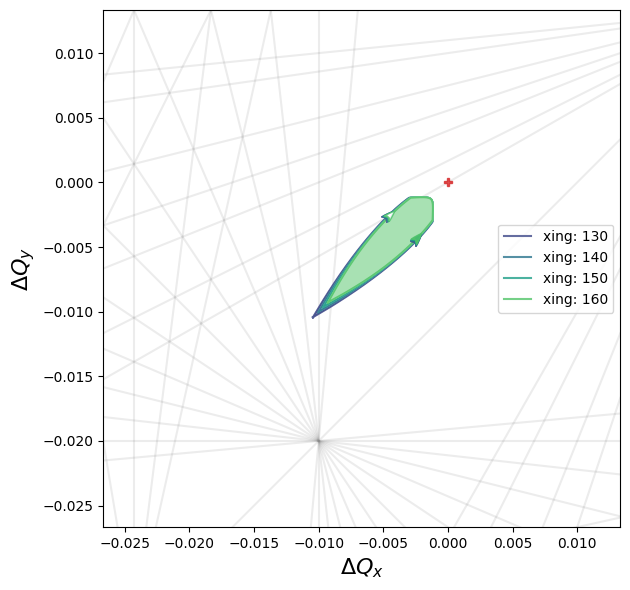

In [76]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*130,vmax=1.1*160,cmap='viridis')

for line_ID in Allconfigs.index[::-1]:
    if 'xing' not in line_ID:
        continue

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'xing'])
    label   = f'xing: {Allconfigs.loc[line_ID,"xing"]}'



    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['HO'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()


---
# Comparing strong beam
---


base_strong_01
base_strong_02
base_strong_03
base_strong_04


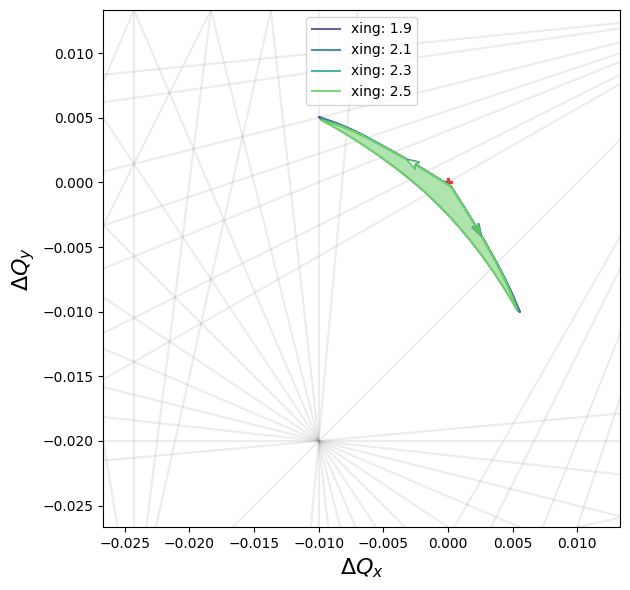

In [64]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*1.9,vmax=1.1*2.5,cmap='viridis')

for line_ID in Allconfigs.index:
    if 'strong' not in line_ID:
        continue
    # if '02' in line_ID:
    #     continue
    # if '03' in line_ID:
    #     continue
    print(line_ID)

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'emitt_strong'])
    label   = f'xing: {Allconfigs.loc[line_ID,"emitt_strong"]}'


    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['LR'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()


base_strong_01
base_strong_02
base_strong_03
base_strong_04


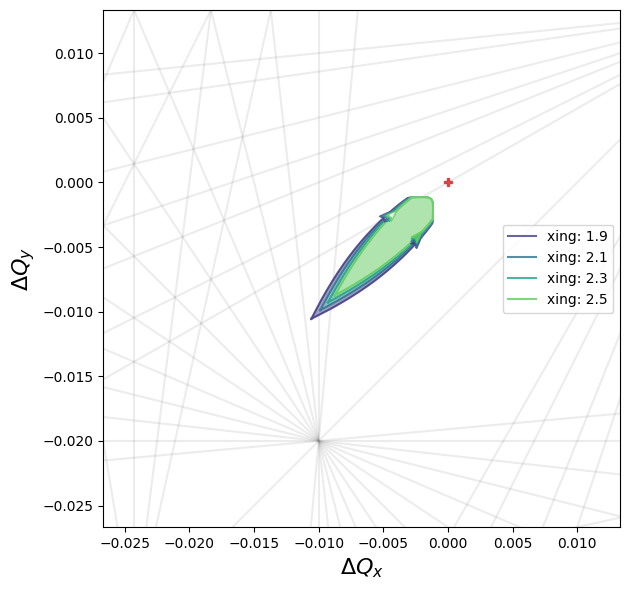

In [74]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*1.9,vmax=1.1*2.5,cmap='viridis')

for line_ID in Allconfigs.index:
    if 'strong' not in line_ID:
        continue
    # if '02' in line_ID:
    #     continue
    # if '03' in line_ID:
    #     continue
    print(line_ID)

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'emitt_strong'])
    label   = f'xing: {Allconfigs.loc[line_ID,"emitt_strong"]}'


    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['HO'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()


---
# Comparing emitt_weak
---

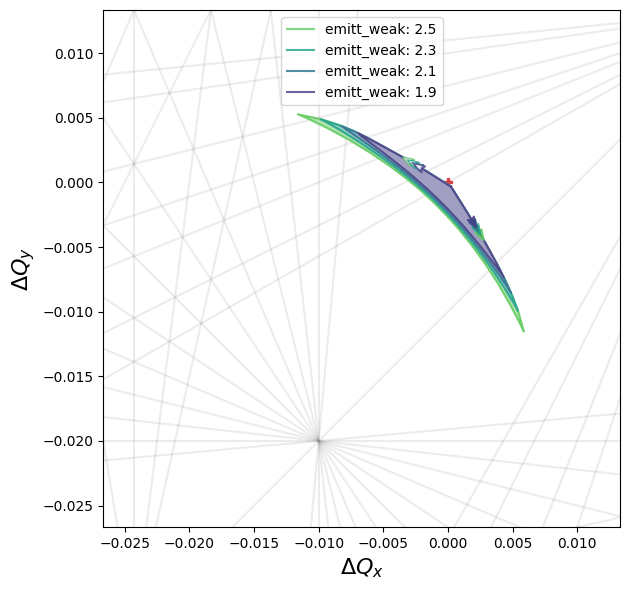

In [68]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*1.9,vmax=1.1*2.5,cmap='viridis')

for line_ID in Allconfigs.index[::-1]:
    if 'weak' not in line_ID:
        continue

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'emitt_weak'])
    label   = f'emitt_weak: {Allconfigs.loc[line_ID,"emitt_weak"]}'



    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['LR'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()

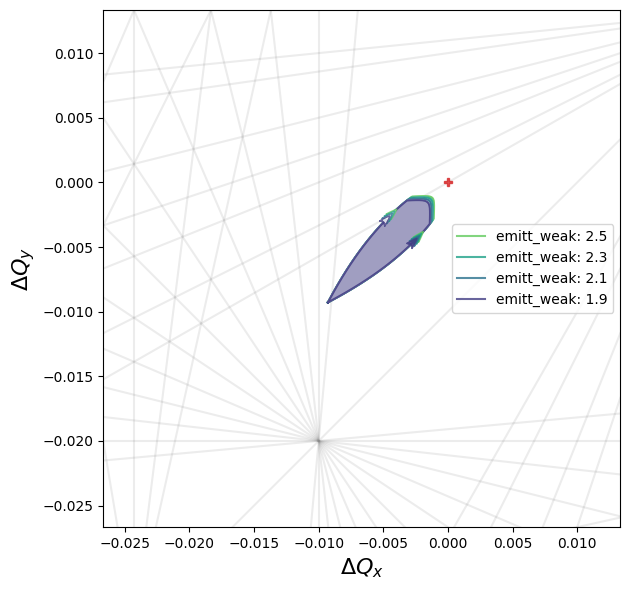

In [71]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*1.9,vmax=1.1*2.5,cmap='viridis')

for line_ID in Allconfigs.index[::-1]:
    if 'weak' not in line_ID:
        continue

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'emitt_weak'])
    label   = f'emitt_weak: {Allconfigs.loc[line_ID,"emitt_weak"]}'



    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['HO'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()

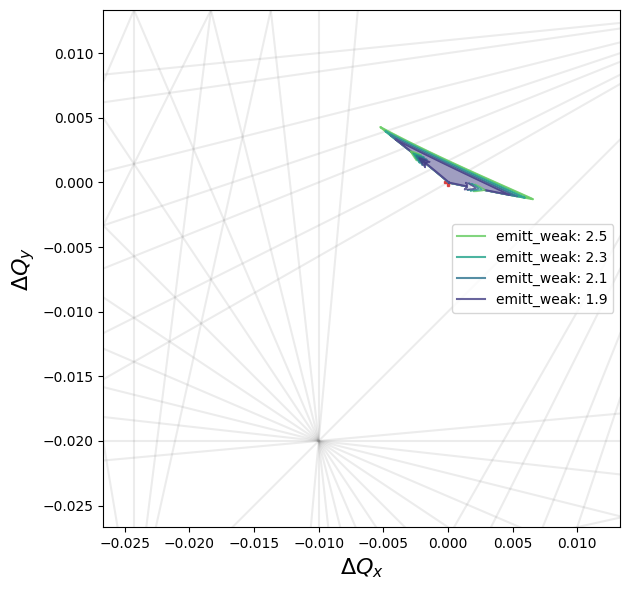

In [72]:

template_FP_plot(window = 0.04)

# Get dummy color
sc = plt.scatter([np.nan],[np.nan],c = np.nan,vmin=0.9*1.9,vmax=1.1*2.5,cmap='viridis')

for line_ID in Allconfigs.index[::-1]:
    if 'weak' not in line_ID:
        continue

    tracked = AllTracked[line_ID]
    color   = sc.to_rgba(Allconfigs.loc[line_ID,'emitt_weak'])
    label   = f'emitt_weak: {Allconfigs.loc[line_ID,"emitt_weak"]}'



    #---------------------------------------------------------
    # Computing footprint
    dQx,dQy = sum_footprints(tracked,components = ['BBCW'])
    _dQx,_dQy = dQx.loc[tracked['not_co']],dQy.loc[tracked['not_co']]
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.3,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color)
    # plt.scatter(_dQx,_dQy,color=color,s = 30*sciStat.norm.pdf(tracked['coord'].loc[_dQx.index,'r_sig'])/sciStat.norm.pdf(0),zorder=10)

    

    # Plotting contour and Jx/J_y
    dQx,dQy = dQx.loc[tracked['ctour_idx']],dQy.loc[tracked['ctour_idx']]
    #plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)
    plt.fill(dQx,dQy,color='w',alpha=1,zorder=2)
    #bbplt.polarmesh(_dQx,_dQy,alpha=0.1,r=tracked['coord'].loc[_dQx.index,'r_sig'],theta=tracked['coord'].loc[_dQx.index,'theta_sig'],color=color,zorder=2)
    plt.fill(dQx,dQy,color=color,alpha=0.5,zorder=2)
    plt.plot(dQx,dQy,'-',alpha=0.8,color=color,label=label)

    start,stop = (len(dQx)-15)//4,(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop],dQy.values[start:stop],scale=1.3,color=color,alpha=0.8,label = None,zorder=100)
    start,stop = 3*(len(dQx)-15)//4,3*(len(dQx)-15)//4+2
    bbplt.drawArrow(dQx.values[start:stop][::-1],dQy.values[start:stop][::-1],scale=1.3,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)
    #---------------------------------------------------------

plt.legend()
plt.tight_layout()

In [79]:
for weak,numID in zip([1.9e-6,2.1e-6,2.3e-6,2.5e-6],['01','02','03','04']):

        emitt_x = weak
        emitt_y = weak
        line_ID = f'base_weak_{numID}'
        print(line_ID,emitt_x,emitt_y)

base_weak_01 1.9e-06 1.9e-06
base_weak_02 2.1e-06 2.1e-06
base_weak_03 2.3e-06 2.3e-06
base_weak_04 2.5e-06 2.5e-06
